In [28]:
# First, loading all relevant libaries. :)

%matplotlib inline
import json
import csv
import numpy as np
import random as rand
import pandas as pd
import scipy as scipy
import datetime as dt
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.mixture import GMM
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import RandomizedPCA

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.grid_search import GridSearchCV

In [29]:
# Second, defining different functions.

def load_json_file(path):
    with open(path) as f:
        data = json.load(f)
    return data

def make_submission_csv(predictions, ids, submission_name, path = '../../predictions'):
    with open(path+'/'+submission_name+'.csv', 'w') as csvfile:
        field_names = ['request_id', 'requester_received_pizza']
        writer = csv.DictWriter(csvfile, fieldnames = field_names)
        writer.writeheader()
        csv_data = zip(ids, predictions)
        for row in csv_data:
            writer.writerow({field_names[0]:row[0], field_names[1]:int(row[1])})

def balance_samples(y, method='oversample'):
    class_counts = np.bincount(y)
    
    maxi = np.argmax(class_counts)
    new_idx = np.argwhere(y==maxi)
    
    for i in range(len(class_counts)):
        if i != maxi:
            mult = class_counts[maxi]/class_counts[i]
            rem = class_counts[maxi] - class_counts[i]*mult
            idxi = np.argwhere(y==i)
            np.random.shuffle(idxi)
            for j in range(mult):
                new_idx = np.vstack((new_idx,idxi))
            new_idx = np.vstack((new_idx,idxi[:rem]))
        
    np.random.shuffle(new_idx)

    return np.reshape(new_idx, (new_idx.shape[0],))

def oversample_kfold(kf, y):
    kf_over = []
    for ti, di in kf:
        yt = y[ti]
        ti_over = ti[balance_samples(yt)]
        kf_over.append((ti_over, di))
    return kf_over

def name2index(df, names):
    return_single = False
    
    if type(names) == type([]):
       names = np.array(names)
    elif type(names) != type(np.array([])):
        names = np.array([names])
        return_single = True 
    
    inds = np.where(np.in1d(df.columns, np.array(names)))[0]
    
    return inds[0] if return_single else inds

def print_scores(scores):
    print 'N: %d, Mean: %f, Median: %f, SD: %f' %(len(scores), np.mean(scores), np.median(scores), np.std(scores))
            
def test_kfolds(X, y, kf, model, verbose=1, balance=False):
    roc_auc_list = []
    
    for train_i, dev_i in kf:
        if balance:
            train_i_orig = train_i
            y_train = y[train_i_orig]
            train_i = train_i_orig[balance_samples(y_train)]
        
        
        X_train = X[train_i]
        X_dev = X[dev_i]

        model.fit(X_train, y[train_i])

        dev_pred = model.predict(X_dev)
        
        roc_auc_i = roc_auc_score(y[dev_i], dev_pred)
        roc_auc_list.append(roc_auc_i)
        if verbose > 1:
            print('ROC AUC:',roc_auc_i)
            
    if verbose > 0:
        print 'N: %d, Mean: %f, Median: %f, SD: %f' %(len(kf), np.mean(roc_auc_list), np.median(roc_auc_list), np.std(roc_auc_list))
        
    return roc_auc_list


In [30]:
#useful for text processing
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

class SnowballStemTokenizer(object):
    def __init__(self):
        self.stmr = SnowballStemmer('english')
    def __call__(self, doc):
        return [self.stmr.stem(t) for t in word_tokenize(doc)]
    
class PorterStemTokenizer(object):
    def __init__(self):
        self.stmr = PorterStemmer()
    def __call__(self, doc):
        return [self.stmr.stem(t) for t in word_tokenize(doc)]



In [31]:
# load data from JSON file as list of dicts
all_train_dict_list = load_json_file('C:/Users/Sarah/Anaconda/Scripts/train.json')
submit_dict_list =  load_json_file('C:/Users/Sarah/Anaconda/Scripts/test.json')

n_all = len(all_train_dict_list)
n_submit = len(submit_dict_list)

# shuffle data to avoid biased split of train / dev data
rand.shuffle(all_train_dict_list)

# set up kFolds
kf = KFold(n_all, n_folds = 10)

# process labels
all_train_labels = np.array([x['requester_received_pizza'] for x in all_train_dict_list])

# pandas is useful for turning dicts in to matrix-like objects
# where each column is an numpy array
submit_df = pd.DataFrame(submit_dict_list)
all_train_df = pd.DataFrame(all_train_dict_list)

# limit train to columns available in submit_df
submit_cols = submit_df.columns
all_train_df = all_train_df[submit_cols]

# useful for sklearn scoring
roc_scorer = make_scorer(roc_auc_score)

In [32]:
y = all_train_labels

kf_over = []
for ti, di in kf:
    yt = y[ti]
    ti_over = ti[balance_samples(yt)]
    kf_over.append((ti_over, di))

# Set up numeric Activity Variables

In [33]:
ACTIVITY_VARS = ['requester_account_age_in_days_at_request',
                'requester_days_since_first_post_on_raop_at_request',
                'requester_number_of_comments_at_request',
                'requester_number_of_comments_in_raop_at_request',
                'requester_number_of_posts_at_request',
                'requester_number_of_posts_on_raop_at_request',
                'requester_number_of_subreddits_at_request',
                'requester_upvotes_minus_downvotes_at_request',
                'requester_upvotes_plus_downvotes_at_request'
                ]
ACTIVITY_COLUMNS = name2index(all_train_df, ACTIVITY_VARS)

class ExtractColumnsTransformer(TransformerMixin):
    
    def __init__(self, cols=[0]):
        self.cols = cols
        
    def fit(self, *args, **kwargs):
        return self
        
    def transform(self, X):
        cols = self.cols
        return X[:,cols]
    
    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.setattr(parameter, value)
        return self

class ExtractActivities(ExtractColumnsTransformer):
    def __init__(self):
        ExtractColumnsTransformer.__init__(self, ACTIVITY_COLUMNS)

In [34]:
# which columns are numeric activity variables
activity_var = ['requester_account_age_in_days_at_request',
                'requester_days_since_first_post_on_raop_at_request',
                'requester_number_of_comments_at_request',
                'requester_number_of_comments_in_raop_at_request',
                'requester_number_of_posts_at_request',
                'requester_number_of_posts_on_raop_at_request',
                'requester_number_of_subreddits_at_request',
                'requester_upvotes_minus_downvotes_at_request',
                'requester_upvotes_plus_downvotes_at_request'
                ]
# look at correlations of requester activity variables:
activity_all = all_train_df.loc[:,activity_var]

scaler = StandardScaler()
X_act = scaler.fit_transform(activity_all)



# Importance of Weighting Classes Appropriately

In [35]:
# Example classification
svc = SVC(class_weight='auto')

print 'Equal Class Weights'
pipe = Pipeline([('activity',ExtractActivities()), ('scale', StandardScaler()),('svc', SVC())])
print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))

print '\nReweighted Classes'
wt_pipe = Pipeline([('activity',ExtractActivities()), ('scale', StandardScaler()),('svc', SVC(class_weight='auto'))])
print_scores(cross_val_score(wt_pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))

print '\nRebalanced Sample'
rebal_pipe = Pipeline([('activity',ExtractActivities()), ('scale', StandardScaler()),('svc',SVC())])
kf_over = oversample_kfold(kf, all_train_labels)
print_scores(cross_val_score(rebal_pipe, all_train_df.values, all_train_labels, cv=kf_over, scoring=roc_scorer))


Equal Class Weights
N: 10, Mean: 0.508304, Median: 0.507514, SD: 0.006603

Reweighted Classes
N: 10, Mean: 0.550112, Median: 0.548468, SD: 0.021276

Rebalanced Sample
N: 10, Mean: 0.552781, Median: 0.556592, SD: 0.024753


# Simple Text Classification

In [36]:
TITLE_COLUMN = name2index(all_train_df, 'request_title')
BODY_COLUMN = name2index(all_train_df, 'request_text_edit_aware')

class ExtractBody(ExtractColumnsTransformer):
    def __init__(self):
        ExtractColumnsTransformer.__init__(self, BODY_COLUMN)
        

class ExtractTitle(ExtractColumnsTransformer):
    def __init__(self):
        ExtractColumnsTransformer.__init__(self, TITLE_COLUMN)



In [37]:
def simple_text(do_all=True, do_count=False,do_tfidf=False, do_titles=False, do_bodies=False, do_both=False, lowercase=False, tokenizer=None):

    # Notes
    # results slightly better w/ lowercase = False (when unigrams only)
    # bigrams added no value on unigrams

    tv = TfidfVectorizer(ngram_range=(1,1),lowercase=lowercase, tokenizer=tokenizer)
    cv = CountVectorizer(ngram_range=(1,1),lowercase=lowercase, tokenizer=tokenizer)
    lsvc = LinearSVC(class_weight='auto', C = 2)
    
    body_cv = Pipeline([('body',ExtractBody()),('cv', cv)])
    body_tv = Pipeline([('body',ExtractBody()),('tv', tv)])
    
    title_cv = Pipeline([('title',ExtractTitle()),('cv', cv)])
    title_tv = Pipeline([('title',ExtractTitle()),('tv', tv)])

    if do_titles or do_all:
        if do_count or do_all:
            # Count Vectorizer Titles
            print '\nCount Vectorizer on Titles'
            
            pipe = Pipeline([('tranform',title_cv),('model',lsvc)])
            print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))

        if do_tfidf or do_all:
            # TFIDF Vectorizer TItles
            print '\nTFIDF Vectorizer on Titles'
            
            pipe = Pipeline([('tranform',title_tv),('model',lsvc)])
            print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))


    if do_bodies or do_all:
        if do_count or do_all:
            # Count Vectorizer Bodies
            print '\nCount Vectorizer on Bodies'
            
            pipe = Pipeline([('tranform',body_cv),('model',lsvc)])
            print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))


        if do_tfidf or do_all:
            # TFIDF Vectorizer Bodies
            print '\nTFIDF Vectorizer on Bodies'
            
            pipe = Pipeline([('tranform',body_tv),('model',lsvc)])
            print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))

        
    if do_both or do_all:
        if do_count or do_all:

            # Count Vectorizer Titles and Bodies
            print '\nCount Vectorizer on Titles and Bodies'
            
            pipe = Pipeline([
                ('features',FeatureUnion([
                    ('tranform_title',title_cv),
                    ('tranform_body',body_cv)
                ])),
                ('model',lsvc)])
            print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))

            
        if do_tfidf or do_all:
            # TFIDF Vectorizer Titles and Bodies
            print '\nTFIDF Vectorizer on Titles and Bodies'
            
            pipe = Pipeline([
                ('features',FeatureUnion([
                    ('tranform_title',title_tv),
                    ('tranform_body',body_tv)
                ])),
                ('model',lsvc)])
            print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))
            
            

In [11]:
simple_text(do_all = True)


Count Vectorizer on Titles
N: 10, Mean: 0.531011, Median: 0.526811, SD: 0.019978

TFIDF Vectorizer on Titles
N: 10, Mean: 0.525430, Median: 0.529828, SD: 0.024463

Count Vectorizer on Bodies
N: 10, Mean: 0.532507, Median: 0.531048, SD: 0.012698

TFIDF Vectorizer on Bodies
N: 10, Mean: 0.537837, Median: 0.546535, SD: 0.018900

Count Vectorizer on Titles and Bodies
N: 10, Mean: 0.534310, Median: 0.531885, SD: 0.015803

TFIDF Vectorizer on Titles and Bodies
N: 10, Mean: 0.537682, Median: 0.543122, SD: 0.012222


Lowercase seems to be a bit worse

In [12]:
print '\nNot Lower Case'
simple_text(do_all=False, do_both=True, lowercase=False, do_tfidf=True)
print '\nLower Case'
simple_text(do_all=False, do_both=True, lowercase=True, do_tfidf=True)


Not Lower Case

TFIDF Vectorizer on Titles and Bodies
N: 10, Mean: 0.537682, Median: 0.543122, SD: 0.012222

Lower Case

TFIDF Vectorizer on Titles and Bodies
N: 10, Mean: 0.535840, Median: 0.532551, SD: 0.017928


Try more complex tokenizers

In [13]:
simple_text(do_all=False, do_both=True, do_tfidf=True, tokenizer=None)
simple_text(do_all=False, do_both=True, do_tfidf=True, tokenizer=SnowballStemTokenizer())


TFIDF Vectorizer on Titles and Bodies
N: 10, Mean: 0.537682, Median: 0.543122, SD: 0.012222

TFIDF Vectorizer on Titles and Bodies
N: 10, Mean: 0.550279, Median: 0.546031, SD: 0.017763


#Text Feature Selection and Dimensionality Reduciton

In [38]:
class LinearWeightFeatureThreshold(TransformerMixin):
    def __init__(
        self,
        model = LinearSVC(class_weight='auto', loss='squared_hinge', penalty='l1', dual=False),
        return_dense = True,
        C = 1,  # I changed this from what Ross was using, was previously 1.
        threshold = 0.01,
        verbose = 1
        ):
        self.model = model
        self.return_dense = return_dense
        self.C = C
        self.threshold = threshold
        self.verbose = verbose
    
    
    def fit(self, X, y):
        model = self.model
        threshold = self.threshold
        verbose = self.verbose
        C = self.C
        
        model.set_params(C=C)
        
        model.fit(X, y)
        coef = model.coef_
        sig_coef = (np.abs(coef) > threshold)[0]
        if verbose > 0:
            print 'kept %d/%d features' % (np.sum(sig_coef), coef.shape[1])
            
        self.sig_coef_  = sig_coef
        return self
    
    def transform(self, X, **transform_params):
        sig_coef = self.sig_coef_
        return_dense = self.return_dense
        
        X_new = X[:,sig_coef]
        
        if return_dense and (type(X_new) != type(np.array(1))):
            X_new = X_new.toarray()
            
        return X_new
    
    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {'C':self.C, 'threshold':self.threshold}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.setattr(parameter, value)
        return self

    

In [75]:
tv = TfidfVectorizer(ngram_range=(1,1), lowercase=False, tokenizer=SnowballStemTokenizer())
l1 = LinearWeightFeatureThreshold()
lsvc = LinearSVC(class_weight='auto')

pipe_lsvc = Pipeline([('tv',tv), ('features',l1), ('lsvc',lsvc)])

title_pipe = Pipeline([('extract', ExtractTitle()),('tv',tv), ('features',l1)])
body_pipe = Pipeline([('extract', ExtractBody()),('tv',tv), ('features',l1)])

print '\nL1 Feature Reduction on Titles w/ LinearSVC'

pipe = Pipeline([('title', title_pipe), ('lsvc', lsvc)])
print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))

print '\nL1 Feature Reduction on Bodies w/ LinearSVC'

pipe = Pipeline([('body', body_pipe), ('lsvc', lsvc)])
print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))


print '\nL1 Feature Reduction on Both w/ LinearSVC'

pipe = Pipeline([
    ('features',FeatureUnion([
        ('title', title_pipe),
        ('body', body_pipe)
    ])),
    ('model',lsvc)
])
print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))

print '\nL1 Feature Reduction on Union w/ LinearSVC'

l1 = LinearWeightFeatureThreshold(C=0.5)
title_pipe = Pipeline([('extract', ExtractTitle()),('tv',tv)])
body_pipe = Pipeline([('extract', ExtractBody()),('tv',tv)])

pipe = Pipeline([
    ('features',FeatureUnion([
        ('title', title_pipe),
        ('body', body_pipe)
    ])),
    ('l1', LinearWeightFeatureThreshold(C=0.5)),
    ('model',lsvc)
])
print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))

print '\nL1 Feature Reduction on Both Individually and on Union w/ LinearSVC'

l1 = LinearWeightFeatureThreshold(C=0.5)
title_pipe = Pipeline([('extract', ExtractTitle()),('tv',tv), ('l1',l1)])
body_pipe = Pipeline([('extract', ExtractBody()),('tv',tv), ('l1',l1)])

pipe = Pipeline([
    ('features',FeatureUnion([
        ('title', title_pipe),
        ('body', body_pipe)
    ])),
    ('l1', LinearWeightFeatureThreshold(C=0.5)),
    ('model',lsvc)
])
print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))


L1 Feature Reduction on Titles w/ LinearSVC
kept 884/3891 features
kept 923/3888 features
kept 925/3897 features
kept 922/3906 features
kept 924/3886 features
kept 921/3906 features
kept 907/3888 features
kept 911/3883 features
kept 892/3884 features
kept 888/3884 features
N: 10, Mean: 0.532637, Median: 0.533453, SD: 0.016016

L1 Feature Reduction on Bodies w/ LinearSVC
kept 783/9930 features
kept 803/9864 features
kept 816/9887 features
kept 817/9926 features
kept 793/9919 features
kept 780/9890 features
kept 785/9884 features
kept 793/9926 features
kept 781/9834 features
kept 775/9835 features
N: 10, Mean: 0.571415, Median: 0.570438, SD: 0.025621

L1 Feature Reduction on Both w/ LinearSVC
kept 881/3891 features
kept 785/9930 features
kept 924/3888 features
kept 805/9864 features
kept 929/3897 features
kept 816/9887 features
kept 922/3906 features
kept 817/9926 features
kept 926/3886 features
kept 794/9919 features
kept 924/3906 features
kept 780/9890 features
kept 912/3888 features


In [76]:
l1 = LinearWeightFeatureThreshold()

gbc = GradientBoostingClassifier(n_estimators = 20,
                           max_depth = 4,
                           min_samples_split=10)

etc = ExtraTreesClassifier(n_estimators = 1000,
                           max_depth = 4,
                           min_samples_split=10,
                           class_weight='auto')

pipe_etc = Pipeline([('extract', ExtractBody()), ('tv',tv), ('features',l1), ('clf',etc)])
pipe_gbc = Pipeline([('extract', ExtractBody()), ('tv',tv), ('features',l1), ('clf',gbc)])

print '\nL1 Feature Reduction on Bodies w/ ETC'
print_scores(cross_val_score(pipe_etc, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))



print '\nL1 Feature Reduction on Bodies w/ GBC'
#need to oversample GBC b/c no class_weight
kf_over = oversample_kfold(kf, all_train_labels)

print_scores(cross_val_score(pipe_gbc, all_train_df.values, all_train_labels, cv=kf_over, scoring=roc_scorer))



L1 Feature Reduction on Bodies w/ ETC
kept 785/9930 features
kept 805/9864 features
kept 815/9887 features
kept 816/9926 features
kept 793/9919 features
kept 781/9890 features
kept 785/9884 features
kept 792/9926 features
kept 780/9834 features
kept 774/9835 features
N: 10, Mean: 0.593885, Median: 0.597486, SD: 0.026327

L1 Feature Reduction on Bodies w/ GBC
kept 1388/9930 features
kept 1344/9864 features
kept 1416/9887 features
kept 1389/9926 features
kept 1390/9919 features
kept 1393/9890 features
kept 1404/9884 features
kept 1393/9926 features
kept 1425/9834 features
kept 1368/9835 features
N: 10, Mean: 0.554435, Median: 0.556324, SD: 0.026936


# Time Features

In [87]:
DATE_TIME_COLUMN_DEFAULT = np.where(all_train_df.columns == 'unix_timestamp_of_request')[0][0]

class TimeTransformer(TransformerMixin):
    
    def __init__(self, date_time_column=DATE_TIME_COLUMN_DEFAULT, do_second=True, do_minute=True, do_hour=True, do_dow=True, do_day=True, do_month=True):
        self.date_time_column = date_time_column
        self.do_second = do_second
        self.do_minute = do_minute
        self.do_hour = do_hour
        self.do_dow = do_dow
        self.do_day = do_day
        self.do_month = do_month
        
    def fit(self, X, y, **fit_params):
        return self
    
    def extract_from_date_time_(self, dt, do_second, do_minute, do_hour, do_dow, do_day, do_month):
        extract = []
        if do_second:
            extract.append(dt.second)
        
        if do_minute:
            extract.append(dt.minute)
            
        if do_hour:
            extract.append(dt.hour)
            
        if do_dow:
            extract.append(dt.weekday())
            
        if do_day:
            extract.append(dt.day)
            
        if do_month:
            extract.append(dt.month)
            
        return extract
    
    def transform(self, X, **transform_params):
        date_time_column = self.date_time_column
        do_second = self.do_second
        do_minute = self.do_minute
        do_hour = self.do_hour
        do_dow = self.do_dow
        do_day = self.do_day
        do_month = self.do_month
        extract_from_date_time = self.extract_from_date_time_
        
        features = np.array([
            extract_from_date_time(dt.datetime.fromtimestamp(timei),
                                   do_second=do_second,
                                   do_minute=do_minute,
                                   do_hour=do_hour,
                                   do_dow=do_dow,
                                   do_day=do_day,
                                   do_month=do_month) for timei in X[:,date_time_column]
        ])
        
        return features
    
    def get_params(self, deep=True):
        return {}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.setattr(parameter, value)
        return self

    

Exploring time features, it looks like requests are not as succesful at late nights / early mornings or on Mondays / Fridays - though that could be because there's more requests on those days.

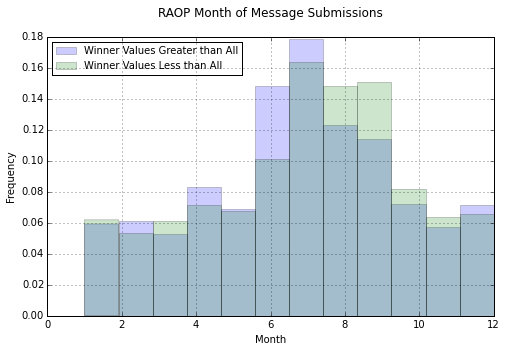

In [97]:
# look at month success
fig = plt.figure(figsize=(8,5))
month = TimeTransformer(do_minute=False, do_day=False, do_second=False, do_hour=False, do_dow=False).transform(all_train_df.values).flatten()
month_pos = month[all_train_labels]
month_neg = month[np.logical_not(all_train_labels)]
pd.Series(month_pos).hist(bins=12, alpha=0.2, normed=True, label='Winner Values Greater than All')
pd.Series(month_neg).hist(bins=12, alpha=0.2, normed=True, label='Winner Values Less than All')
plt.title("RAOP Month of Message Submissions \n")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.rcParams['legend.fontsize'] = 10
plt.legend(loc='best')
plt.show()

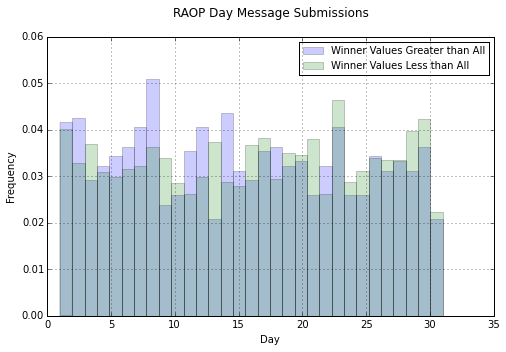

In [98]:
# look at day success
fig = plt.figure(figsize=(8,5))
day = TimeTransformer(do_hour=False, do_dow=False, do_month=False, do_minute=False, do_second=False).transform(all_train_df.values).flatten()
day_pos = day[all_train_labels]
day_neg = day[np.logical_not(all_train_labels)]
pd.Series(day_pos).hist(bins=31, alpha=0.2, normed=True, label='Winner Values Greater than All')
pd.Series(day_neg).hist(bins=31, alpha=0.2, normed=True, label='Winner Values Less than All')
plt.title("RAOP Day Message Submissions \n")
plt.xlabel("Day")
plt.ylabel("Frequency")
plt.rcParams['legend.fontsize'] = 10
plt.legend(loc='best')
plt.show()


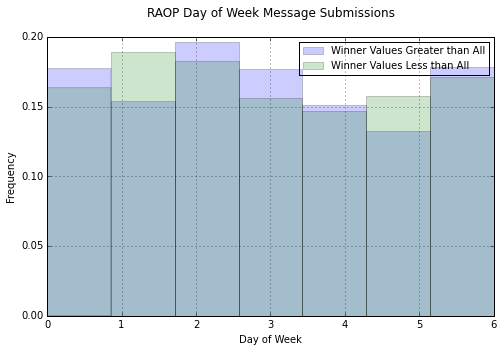

In [99]:
# look at day of week success
fig = plt.figure(figsize=(8,5))
dow = TimeTransformer(do_hour=False, do_month=False, do_day=False, do_minute=False, do_second=False).transform(all_train_df.values).flatten()
dow_pos = dow[all_train_labels]
dow_neg = dow[np.logical_not(all_train_labels)]
pd.Series(dow_pos).hist(bins=7, alpha=0.2, normed=True, label='Winner Values Greater than All')
pd.Series(dow_neg).hist(bins=7, alpha=0.2, normed=True, label='Winner Values Less than All')
plt.title("RAOP Day of Week Message Submissions \n")
plt.xlabel("Day of Week")
plt.ylabel("Frequency")
plt.rcParams['legend.fontsize'] = 10
plt.legend(loc='best')
plt.show()

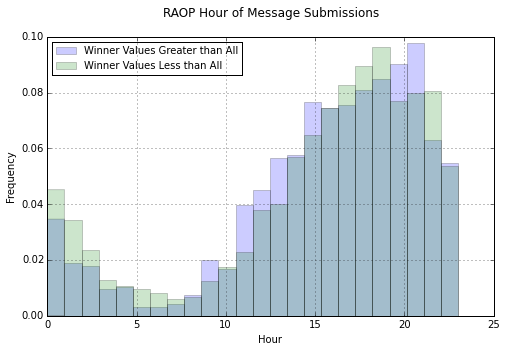

In [100]:
# look at hourly success
fig = plt.figure(figsize=(8,5))
hour = TimeTransformer(do_dow=False, do_month=False, do_day=False, do_minute=False, do_second=False).transform(all_train_df.values).flatten()
hour_pos = hour[all_train_labels]
hour_neg = hour[np.logical_not(all_train_labels)]
pd.Series(hour_pos).hist(bins=24, alpha=0.2, normed=True, label='Winner Values Greater than All')
pd.Series(hour_neg).hist(bins=24, alpha=0.2, normed=True, label='Winner Values Less than All')
plt.title("RAOP Hour of Message Submissions \n")
plt.xlabel("Hour")
plt.ylabel("Frequency")
plt.rcParams['legend.fontsize'] = 10
plt.legend(loc='best')
plt.show()


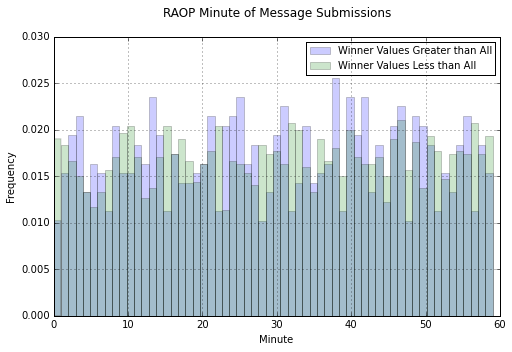

In [101]:
# look at minute success
fig = plt.figure(figsize=(8,5))
minute = TimeTransformer(do_month=False, do_day=False, do_second=False, do_hour=False, do_dow=False).transform(all_train_df.values).flatten()
minute_pos = minute[all_train_labels]
minute_neg = minute[np.logical_not(all_train_labels)]
pd.Series(minute_pos).hist(bins=60, alpha=0.2, normed=True, label='Winner Values Greater than All')
pd.Series(minute_neg).hist(bins=60, alpha=0.2, normed=True, label='Winner Values Less than All')
plt.title("RAOP Minute of Message Submissions \n")
plt.xlabel("Minute")
plt.ylabel("Frequency")
plt.rcParams['legend.fontsize'] = 10
plt.legend(loc='best')
plt.show()

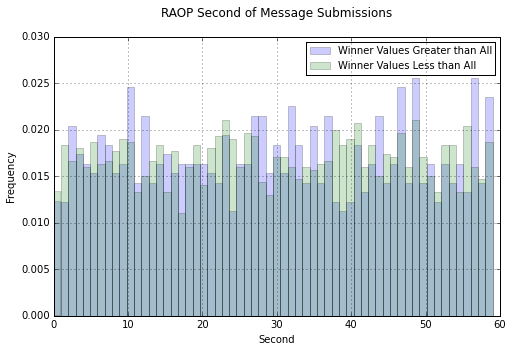

In [102]:
# look at second success
fig = plt.figure(figsize=(8,5))
second = TimeTransformer(do_month=False, do_day=False, do_minute=False, do_hour=False, do_dow=False).transform(all_train_df.values).flatten()
second_pos = second[all_train_labels]
second_neg = second[np.logical_not(all_train_labels)]
pd.Series(second_pos).hist(bins=60, alpha=0.2, normed=True, label='Winner Values Greater than All')
pd.Series(second_neg).hist(bins=60, alpha=0.2, normed=True, label='Winner Values Less than All')
plt.title("RAOP Second of Message Submissions \n")
plt.xlabel("Second")
plt.ylabel("Frequency")
plt.rcParams['legend.fontsize'] = 10
plt.legend(loc='best')
plt.show()

Times not a very useful classifier by themselves, but maybe in conjuctions with others

In [70]:
# classifier based on times

svc = Pipeline([('scaler',StandardScaler()), ('svc',SVC(class_weight='auto'))])

print '\nSVC'
svc_pipe = Pipeline([
    ('time',TimeTransformer()),
    ('model',svc)
    ])

print_scores(cross_val_score(svc_pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))

print '\nExtra Tree Ensemble'
etc = ExtraTreesClassifier(n_estimators=1000,
                           max_depth = 5,
                           min_samples_split=10,
                           class_weight='auto')

etc_pipe = Pipeline([
    ('time',TimeTransformer()),
    ('model',etc)
    ])

print_scores(cross_val_score(etc_pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))



SVC
N: 10, Mean: 0.525038, Median: 0.522776, SD: 0.020851

Extra Tree Ensemble
N: 10, Mean: 0.518677, Median: 0.516243, SD: 0.030192


#Text Summary Features

In [103]:
TITLE_COLUMN = np.where(all_train_df.columns == 'request_title')[0][0]
BODY_COLUMN = np.where(all_train_df.columns == 'request_text_edit_aware')[0][0]

class TextSummaryTransformer(TransformerMixin):
    def __init__(self, title_col=TITLE_COLUMN, body_col=BODY_COLUMN, do_title=True, do_body=True):
        self.do_title = do_title
        self.do_body = do_body
        self.title_col = title_col
        self.body_col = body_col

    def transform(self, X, **transform_params):
        do_title = self.do_title
        do_body = self.do_body
        title_col = self.title_col
        body_col = self.body_col
        
        features = []
        
        if do_title:
            title_unicode = X[:, title_col]
            title_len = np.array([[len(x.encode('utf-8')) for x in title_unicode]]).T
            features.append(title_len)
            
        if do_body:
            body_unicode = X[:, body_col]
            body_len = np.array([[len(x.encode('utf-8')) for x in body_unicode]]).T
            features.append(body_len)
        
        return np.hstack(tuple(features))
        
    def fit(self, X, y, **fit_params):
        #do nothing
        return self 
    
    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.setattr(parameter, value)
        return self


### Title and Body character length
Not at all useful based on linear classifiers... but lots of value added with tree ensembles

In [72]:
# create some text derivative features
# title character length
title_unicode = all_train_df.request_title.values
title_len = np.array([[len(x.encode('utf-8')) for x in title_unicode]]).T

# body character length
body_unicode = all_train_df.request_text_edit_aware.values
body_len = np.array([[len(x.encode('utf-8')) for x in body_unicode]]).T


X_text_summary = np.hstack((title_len, body_len))


etc = ExtraTreesClassifier(n_estimators = 1000,
                           max_depth = 5,
                           min_samples_split=10,
                           class_weight='auto')

gbc = GradientBoostingClassifier(n_estimators = 20,
                           max_depth = 5,
                           min_samples_split=10)

svc = SVC(class_weight='auto')

print '\nSVC on title and body length'
pipe = Pipeline([('text_summary', TextSummaryTransformer()), ('svc', svc)])
print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))

print '\nExtra Trees Classifier on title and body length'
pipe = Pipeline([('text_summary', TextSummaryTransformer()), ('etc', etc)])
print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=roc_scorer))

print '\nGradient Boosting on title and body length'
pipe = Pipeline([('text_summary', TextSummaryTransformer()), ('gbc', gbc)])
kf_over = oversample_kfold(kf, all_train_labels)
print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf_over, scoring=roc_scorer))



SVC on title and body length
N: 10, Mean: 0.492842, Median: 0.493482, SD: 0.006771

Extra Trees Classifier on title and body length
N: 10, Mean: 0.573922, Median: 0.576208, SD: 0.024123

Gradient Boosting on title and body length
N: 10, Mean: 0.579064, Median: 0.578002, SD: 0.016136


# Interesting Words

In [104]:
TITLE_COLUMN = np.where(all_train_df.columns == 'request_title')[0][0]
BODY_COLUMN = np.where(all_train_df.columns == 'request_text_edit_aware')[0][0]

class InterestingWordsTransformer(TransformerMixin):
    def __init__(self, title_col = TITLE_COLUMN, body_col=BODY_COLUMN, do_title=True, do_body=True, do_tags=True, do_words=True):
        self.do_title = do_title
        self.do_body = do_body
        self.do_tags = do_tags
        self.do_words = do_words
        self.title_col = title_col
        self.body_col = body_col
        
        self.keywords = {
            'sad_food': ['hungry', 'starving', 'no food', 'grocer', 'eaten', 'hunger', 'ramen', 'empty', 'fridge', 'refrig'],
            'money': ['broke', 'paid', 'money', 'unemployed', 'lost', 'job', 'bill', 'wage', 'work', 'payday', 'paycheck', 'funds', 'cash', 'bank', 'laid off', 'poor', 'payroll'],
            'sad': ['worst', 'awful', 'sick', 'problem', 'catch a break', 'cheer', 'hospital', 'bad', 'shitty', 'stress', 'luck', ':(', 'rough', 'tough', 'battle', 'reasons', 'losing'],
            'military': ['military', 'veteran', 'soldier', 'army', 'navy', 'marine', 'air force', 'iraq', 'afghanis'],
            'happy': ['celebrate', 'birthday', 'party', 'new year', 'bday', 'engage', 'annivers', 'surprise', 'loves', 'best'],
            'nice': ['please', 'help', 'thank you', ':)', 'helping', 'aid', 'exchange', 'spare'],
            'honest': ['sob story', 'honest', 'just want', 'just because'],
            'parent': ['family', 'kids', 'parent', 'mom', 'mommy', 'mother', 'dad', 'father', 'baby', 'boy', 'girl'],
            'relationship': ['husband', 'wife', 'girlfriend', 'boyfriend', 'fianc', 'roommates', 'married'],
            'test': ['study', 'test', 'final', 'midterm'],
            'time': ['yesterday', 'lately', 'never', 'during', 'sunday', 'constantly']
        }
    
    def find_tag_words(self, keywords, text):
        word_dict = {}
        tag_dict = {}

        for tag, words in keywords.iteritems():

            tag_count = None

            for word in words:
                has_word = np.array([(1 if word in t else 0) for t in text])
                word_dict[word] = has_word

                if tag_count is None:
                    tag_count = has_word
                else:
                    tag_count = tag_count +  has_word

            tag_dict[tag] = tag_count

        return (tag_dict, word_dict)
    
    # manually create keywords with categories
    
    def transform(self, X, **transform_params):
        do_title = self.do_title
        do_tags = self.do_tags
        do_words = self.do_words
        do_body = self.do_body
        keywords = self.keywords
        find_tag_words = self.find_tag_words
        body_col = self.body_col
        title_col = self.title_col
        
        features = []
        feature_names = []

        # find keywords and tags
        if do_title:
            title_unicode = np.array([x.lower() for x in X[:,title_col]])
            title_tag_dict, title_word_dict = find_tag_words(keywords, title_unicode)

            if do_tags:
                features.append(pd.DataFrame(title_tag_dict).values)
                feature_names.append('title_tags')
            if do_words:
                features.append(pd.DataFrame(title_word_dict).values)
                feature_names.append('title_words')

        if do_body:
            body_unicode = np.array([x.lower() for x in X[:,body_col]])
            body_tag_dict, body_word_dict = find_tag_words(keywords, body_unicode)

            if do_tags:
                features.append(pd.DataFrame(body_tag_dict).values)
                feature_names.append('body_tags')

            if do_words:
                features.append(pd.DataFrame(body_word_dict).values)
                feature_names.append('body_words')

        return np.hstack(tuple(features))
    
    def fit(self, X, y, **fit_params):
        #do nothing
        return self
    
    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.setattr(parameter, value)
        return self

    

In [105]:
print_scores(scores)

NameError: name 'scores' is not defined

In [106]:
# train a model based on keywords and tags

etc = ExtraTreesClassifier(n_estimators = 1000,
                           max_depth = 4,
                           min_samples_split=10,
                           class_weight='auto')

etc_oob = ExtraTreesClassifier(n_estimators = 1000,
                           max_depth = 4,
                           min_samples_split=10,
                           oob_score = True,
                           bootstrap=True,
                           class_weight='auto')

gbc = GradientBoostingClassifier(n_estimators = 20,
                           max_depth = 4,
                           min_samples_split=10)


lsvc = Pipeline([('scale', StandardScaler()), ('clf', LinearSVC(class_weight='auto'))])

lsvc_pca = Pipeline([('scale', StandardScaler()),('pca', RandomizedPCA(n_components=3)), ('clf', LinearSVC(class_weight='auto'))])

lsvc_l1 = Pipeline([('scale', StandardScaler()),('l1', LinearWeightFeatureThreshold(C=0.05)), ('clf', LinearSVC(class_weight='auto'))])



models = {'Extra Trees':etc, 'ET Out Of Bag':etc_oob, 'Gradient Boosting':gbc, 'Linear SVC':lsvc, 'Linear SVC PCA 3':lsvc_pca}
kf_over = oversample_kfold(kf, all_train_labels)

print '\n##############'
print 'Body & Title Tags'
trans = InterestingWordsTransformer(do_words=False)
X_tag = trans.transform(all_train_df.values)

for name, model in models.iteritems():
    print '\n%s' % name
    kfi = kf_over if (name=='Gradient Boosting') else kf
    pipe = Pipeline([('trans',trans),('model',model)])
    print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kfi, scoring=roc_scorer))
    
    test_kfolds(X_tag, all_train_labels, kf, model, balance = (name=='Gradient Boosting'))


print '\n##############'
print 'Body & Title Words'
trans = InterestingWordsTransformer(do_tags=False)
X_tag = trans.transform(all_train_df.values)

for name, model in models.iteritems():
    print '\n%s' % name
    kfi = kf_over if (name=='Gradient Boosting') else kf
    pipe = Pipeline([('trans',trans),('model',model)])
    print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kfi, scoring=roc_scorer))

    test_kfolds(X_tag, all_train_labels, kf, model, balance = (name=='Gradient Boosting'))


print '\n##############'
print 'Body & Title Words & Tags'
trans = InterestingWordsTransformer()
X_tag = trans.transform(all_train_df.values)

for name, model in models.iteritems():
    print '\n%s' % name
    kfi = kf_over if (name=='Gradient Boosting') else kf
    pipe = Pipeline([('trans',trans),('model',model)])
    print_scores(cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kfi, scoring=roc_scorer))

    test_kfolds(X_tag, all_train_labels, kf, model, balance = (name=='Gradient Boosting'))



##############
Body & Title Tags

Gradient Boosting
N: 10, Mean: 0.552136, Median: 0.547012, SD: 0.024553
N: 10, Mean: 0.555422, Median: 0.550441, SD: 0.023352

Linear SVC PCA 3
N: 10, Mean: 0.564102, Median: 0.560335, SD: 0.028366
N: 10, Mean: 0.566635, Median: 0.570686, SD: 0.029929

Linear SVC
N: 10, Mean: 0.558113, Median: 0.556727, SD: 0.025205
N: 10, Mean: 0.569671, Median: 0.562911, SD: 0.029765

ET Out Of Bag
N: 10, Mean: 0.569256, Median: 0.576491, SD: 0.028233
N: 10, Mean: 0.567297, Median: 0.551219, SD: 0.031585

Extra Trees
N: 10, Mean: 0.572192, Median: 0.573028, SD: 0.027858
N: 10, Mean: 0.568351, Median: 0.554027, SD: 0.032918

##############
Body & Title Words

Gradient Boosting
N: 10, Mean: 0.552090, Median: 0.547718, SD: 0.024404
N: 10, Mean: 0.558503, Median: 0.565408, SD: 0.025779

Linear SVC PCA 3
N: 10, Mean: 0.568847, Median: 0.573768, SD: 0.028680
N: 10, Mean: 0.566500, Median: 0.570095, SD: 0.028328

Linear SVC
N: 10, Mean: 0.557304, Median: 0.559308, SD: 0.02

In [42]:
etc = ExtraTreesClassifier(n_estimators = 1000,
                           max_depth = 2,
                           min_samples_split=10,
                           class_weight='auto')

etc_oob = ExtraTreesClassifier(n_estimators = 1000,
                           max_depth = 2,
                           min_samples_split=10,
                           oob_score = True,
                           bootstrap=True,
                           class_weight='auto')

gbc = GradientBoostingClassifier(n_estimators = 20,
                           max_depth = 4,
                           min_samples_split=10)


lsvc = Pipeline([('scale', StandardScaler()), ('clf', LinearSVC(class_weight='auto'))])

lsvc_pca = Pipeline([('scale', StandardScaler()),('pca', RandomizedPCA(n_components=3)), ('clf', LinearSVC(class_weight='auto'))])

lsvc_l1 = Pipeline([('scale', StandardScaler()),('l1', LinearWeightFeatureThreshold(C=0.05)), ('clf', LinearSVC(class_weight='auto'))])


megapipe = Pipeline([
    ('subsets', FeatureUnion([
        ('title_tags', Pipeline([
            ('interesting',InterestingWordsTransformer(do_body=False,do_words=False)),
            ('models', FeatureUnion([
                ('etc', etc),
                ('etc_oob', etc_oob),
                ('lsvc', lsvc),
                ('lsvc_pca', lsvc_pca),
            ]))
        ])),
        ('body_tags', Pipeline([
            ('interesting',InterestingWordsTransformer(do_title=False,do_words=False)),
            ('models', FeatureUnion([
                ('etc', etc),
                ('etc_oob', etc_oob),
                ('lsvc', lsvc),
                ('lsvc_pca', lsvc_pca)
            ]))
        ])),
        ('title_words', Pipeline([
            ('interesting',InterestingWordsTransformer(do_body=False,do_tags=False)),
            ('models', FeatureUnion([
                ('etc', etc),
                ('etc_oob', etc_oob),
                ('lsvc', lsvc),
                ('lsvc_pca', lsvc_pca),
                ('lsvc_l1', lsvc_l1)
            ]))
        ])),
        ('title_tags', Pipeline([
            ('interesting',InterestingWordsTransformer(do_title=False,do_tags=False)),
            ('models', FeatureUnion([
                ('etc', etc),
                ('etc_oob', etc_oob),
                ('lsvc', lsvc),
                ('lsvc_pca', lsvc_pca),
                ('lsvc_l1', lsvc_l1)
            ]))
        ])),
    ])),
    ('ensemble', etc)
])

TypeError: __init__() got an unexpected keyword argument 'class_weight'

In [43]:

scorer = make_scorer(roc_auc_score)
scores = cross_val_score(megapipe, all_train_df.values, all_train_labels, cv=kf, scoring=scorer)



NameError: name 'megapipe' is not defined

In [44]:

etc = ExtraTreesClassifier(n_estimators = 1000,
                           max_depth = 5,
                           min_samples_split=10,
                           class_weight='auto')


pipe = Pipeline([
    ('preprocess', FeatureUnion([
        ('tsum', TextSummaryTransformer()),
        ('tags', InterestingWordsTransformer(do_words=False))
        ])
    ),
    ('etc', etc)
])


scores = cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=scorer)


TypeError: __init__() got an unexpected keyword argument 'class_weight'

# Combine Feature Sets

In [376]:
tv = TfidfVectorizer(ngram_range=(1,1),lowercase=True, tokenizer=SnowballStemTokenizer())
etc = ExtraTreesClassifier(n_estimators = 1000,
                           max_depth = 4,
                           min_samples_split=10,
                           class_weight='auto')
kf = KFold(n_all, n_folds = 5)


In [377]:

pipe = Pipeline([
    ('preprocess', FeatureUnion([
        ('body_l1', Pipeline([
            ('body', ExtractBody()),
            ('tv', tv),
            ('l1', LinearWeightFeatureThreshold(C=0.5))
        ])),
        ('title_l1', Pipeline([
            ('title',ExtractTitle()),
            ('tv', tv),
            ('l1', LinearWeightFeatureThreshold(C=0.5))
        ])),
        ('activity',ExtractActivities()),
        ('time', TimeTransformer()),
        ('text_summary', TextSummaryTransformer()),
        ('interesting', InterestingWordsTransformer(do_tags=True, do_words=True))
    ])),
    ('model', etc)
])

scores = cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=scorer)

print_scores(scores)

kept 56/9149 features
kept 19/3654 features
kept 49/9381 features
kept 28/3664 features
kept 60/9167 features
kept 20/3661 features
kept 60/9378 features
kept 21/3678 features
kept 52/9332 features
kept 25/3653 features
N: 5, Mean: 0.603441, Median: 0.599189, SD: 0.014246


N: 10, Mean: 0.604379, Median: 0.600186, SD: 0.022009


In [410]:

pipe = Pipeline([
    ('preprocess', FeatureUnion([
        ('body_l1', Pipeline([
            ('body', ExtractBody()),
            ('tv', tv),
            ('l1', LinearWeightFeatureThreshold(C=0.5))
        ])),
        #('title_l1', Pipeline([
        #    ('title',ExtractTitle()),
        #    ('tv', tv),
        #    ('l1', LinearWeightFeatureThreshold(C=0.5))
        #])),
        ('activity',ExtractActivities()),
        ('time', TimeTransformer()),
        ('text_summary', TextSummaryTransformer()),
        ('interesting', InterestingWordsTransformer(do_tags=True, do_words=True))
    ])),
    ('scaler', StandardScaler()),
    ('l1', LinearWeightFeatureThreshold(C=0.5)),
    ('model', etc)
])

#scores = cross_val_score(pipe, all_train_df.values, all_train_labels, cv=kf, scoring=scorer, verbose=1)

#print_scores(scores)

In [433]:
pipe = Pipeline([
    ('preprocess', FeatureUnion([
        ('body_l1', Pipeline([
            ('body', ExtractBody()),
            ('tv', tv),
            ('l1', LinearWeightFeatureThreshold(C=0.5))
        ])),
        #('title_l1', Pipeline([
        #    ('title',ExtractTitle()),
        #    ('tv', tv),
        #    ('l1', LinearWeightFeatureThreshold(C=0.5))
        #])),
        ('activity',ExtractActivities()),
        ('time', TimeTransformer()),
        ('text_summary', TextSummaryTransformer()),
        ('interesting', InterestingWordsTransformer(do_tags=True, do_words=True))
    ])),
    ('scaler', StandardScaler()),
    #('l1', LinearWeightFeatureThreshold(C=0.5)),
    ('model', etc)
])

In [434]:
gs = GridSearchCV(pipe, {'model__max_depth':[2,5,10], 'model__min_samples_split':[5,15,30], 'model__n_estimators':[10,100,1000]}, cv=kf, scoring=scorer)

In [435]:
gs_out = gs.fit(all_train_df.values, all_train_labels)

kept 56/9149 features
kept 49/9381 features
kept 60/9167 features
kept 60/9378 features
kept 52/9332 features
kept 56/9149 features
kept 49/9381 features
kept 60/9167 features
kept 60/9378 features
kept 52/9332 features
kept 56/9149 features
kept 49/9381 features
kept 60/9167 features
kept 60/9378 features
kept 52/9332 features
kept 56/9149 features
kept 49/9381 features
kept 60/9167 features
kept 60/9378 features
kept 52/9332 features
kept 56/9149 features
kept 49/9381 features
kept 60/9167 features
kept 60/9378 features
kept 52/9332 features
kept 56/9149 features
kept 49/9381 features
kept 60/9167 features
kept 60/9378 features
kept 52/9332 features
kept 56/9149 features
kept 49/9381 features
kept 60/9167 features
kept 60/9378 features
kept 52/9332 features
kept 56/9149 features
kept 49/9381 features
kept 60/9167 features
kept 60/9378 features
kept 52/9332 features
kept 56/9149 features
kept 49/9381 features
kept 60/9167 features
kept 60/9378 features
kept 52/9332 features
kept 56/91

In [438]:
gs_out.grid_scores_

[mean: 0.56231, std: 0.02606, params: {'model__min_samples_split': 5, 'model__max_depth': 2, 'model__n_estimators': 10},
 mean: 0.59372, std: 0.01838, params: {'model__min_samples_split': 5, 'model__max_depth': 2, 'model__n_estimators': 100},
 mean: 0.60112, std: 0.01604, params: {'model__min_samples_split': 5, 'model__max_depth': 2, 'model__n_estimators': 1000},
 mean: 0.57620, std: 0.01930, params: {'model__min_samples_split': 15, 'model__max_depth': 2, 'model__n_estimators': 10},
 mean: 0.60701, std: 0.00887, params: {'model__min_samples_split': 15, 'model__max_depth': 2, 'model__n_estimators': 100},
 mean: 0.59932, std: 0.01495, params: {'model__min_samples_split': 15, 'model__max_depth': 2, 'model__n_estimators': 1000},
 mean: 0.57421, std: 0.01948, params: {'model__min_samples_split': 30, 'model__max_depth': 2, 'model__n_estimators': 10},
 mean: 0.59124, std: 0.00913, params: {'model__min_samples_split': 30, 'model__max_depth': 2, 'model__n_estimators': 100},
 mean: 0.60015, std:

In [442]:
gbc = GradientBoostingClassifier(n_estimators = 20,
                           max_depth = 4,
                           min_samples_split=10)


In [443]:
pipe = Pipeline([
    ('preprocess', FeatureUnion([
        ('body_l1', Pipeline([
            ('body', ExtractBody()),
            ('tv', tv),
            ('l1', LinearWeightFeatureThreshold(C=0.5))
        ])),
        #('title_l1', Pipeline([
        #    ('title',ExtractTitle()),
        #    ('tv', tv),
        #    ('l1', LinearWeightFeatureThreshold(C=0.5))
        #])),
        ('activity',ExtractActivities()),
        ('time', TimeTransformer()),
        ('text_summary', TextSummaryTransformer()),
        ('interesting', InterestingWordsTransformer(do_tags=True, do_words=True))
    ])),
    #('scaler', StandardScaler()),
    #('l1', LinearWeightFeatureThreshold(C=0.5)),
    ('model', gbc)
])

In [444]:
kf_over = oversample_kfold(kf, all_train_labels)

In [445]:
gs = GridSearchCV(pipe, {'model__learning_rate':[.01,.1,1,5], 'model__n_estimators':[20,100,200]}, cv=kf_over, scoring=scorer)

In [446]:
gs_out = gs.fit(all_train_df.values, all_train_labels)

kept 168/9149 features
kept 182/9381 features
kept 166/9167 features
kept 190/9378 features
kept 177/9332 features
kept 168/9149 features
kept 182/9381 features
kept 166/9167 features
kept 190/9378 features
kept 177/9332 features
kept 168/9149 features
kept 182/9381 features
kept 166/9167 features
kept 190/9378 features
kept 177/9332 features
kept 168/9149 features
kept 182/9381 features
kept 166/9167 features
kept 190/9378 features
kept 177/9332 features
kept 168/9149 features
kept 182/9381 features
kept 166/9167 features
kept 190/9378 features
kept 177/9332 features
kept 168/9149 features
kept 182/9381 features
kept 166/9167 features
kept 190/9378 features
kept 177/9332 features
kept 168/9149 features
kept 182/9381 features
kept 166/9167 features
kept 190/9378 features
kept 177/9332 features
kept 168/9149 features
kept 182/9381 features
kept 166/9167 features
kept 190/9378 features
kept 177/9332 features
kept 168/9149 features
kept 182/9381 features
kept 166/9167 features
kept 190/93

In [448]:
gs_out.grid_scores_

[mean: 0.59138, std: 0.01668, params: {'model__learning_rate': 0.01, 'model__n_estimators': 20},
 mean: 0.59708, std: 0.01149, params: {'model__learning_rate': 0.01, 'model__n_estimators': 100},
 mean: 0.60140, std: 0.00658, params: {'model__learning_rate': 0.01, 'model__n_estimators': 200},
 mean: 0.59951, std: 0.01125, params: {'model__learning_rate': 0.1, 'model__n_estimators': 20},
 mean: 0.58094, std: 0.01407, params: {'model__learning_rate': 0.1, 'model__n_estimators': 100},
 mean: 0.57900, std: 0.00585, params: {'model__learning_rate': 0.1, 'model__n_estimators': 200},
 mean: 0.56158, std: 0.00434, params: {'model__learning_rate': 1, 'model__n_estimators': 20},
 mean: 0.55415, std: 0.01995, params: {'model__learning_rate': 1, 'model__n_estimators': 100},
 mean: 0.54720, std: 0.00403, params: {'model__learning_rate': 1, 'model__n_estimators': 200},
 mean: 0.47438, std: 0.03003, params: {'model__learning_rate': 5, 'model__n_estimators': 20},
 mean: 0.47924, std: 0.01348, params: {